**Setting up Spark on our Colab environment.**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
cur_path = "/content/drive/MyDrive/renaming_folder/final_project/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/renaming_folder/final_project


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('final_project').getOrCreate()

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
#sc= SparkContext()
sqlContext = SQLContext(spark)
data = spark.read.csv(cur_path + 'DisneylandReviews.csv',inferSchema=True,header=True)

In [ ]:
data.show()

+---------+------+----------+--------------------+--------------------+-------------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|
+---------+------+----------+--------------------+--------------------+-------------------+
|670772142|     4|    2019-4|           Australia|If you've ever be...|Disneyland_HongKong|
|670682799|     4|    2019-5|         Philippines|Its been a while ...|Disneyland_HongKong|
|670623270|     4|    2019-4|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|
|670607911|     4|    2019-4|           Australia|HK Disneyland is ...|Disneyland_HongKong|
|670607296|     4|    2019-4|      United Kingdom|the location is n...|Disneyland_HongKong|
|670591897|     3|    2019-4|           Singapore|Have been to Disn...|Disneyland_HongKong|
|670585330|     5|    2019-4|               India|Great place! Your...|Disneyland_HongKong|
|670574142|     3|    2019-3|            Malaysia|Think of it as an...|Disneylan

In [ ]:
print((data.count(), len(data.columns)))

(42656, 6)


##### Our dataset has 42,656 rows and 8 columns.

#### **Checking for NA values:**

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+---------+------+----------+-----------------+-----------+------+
|Review_ID|Rating|Year_Month|Reviewer_Location|Review_Text|Branch|
+---------+------+----------+-----------------+-----------+------+
|        0|     0|         0|                0|          0|     0|
+---------+------+----------+-----------------+-----------+------+



In [ ]:
data.printSchema()

root
 |-- Review_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Year_Month: string (nullable = true)
 |-- Reviewer_Location: string (nullable = true)
 |-- Review_Text: string (nullable = true)
 |-- Branch: string (nullable = true)



#### **changing date column to type datetime**

In [ ]:
from pyspark.sql.types import TimestampType 
from pyspark.sql.types import DateType 

data = data.withColumn('Year_Month', data['Year_Month'].cast(DateType()))

In [ ]:
data.printSchema()

root
 |-- Review_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Year_Month: date (nullable = true)
 |-- Reviewer_Location: string (nullable = true)
 |-- Review_Text: string (nullable = true)
 |-- Branch: string (nullable = true)



In [ ]:
data.show()

+---------+------+----------+--------------------+--------------------+-------------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|
+---------+------+----------+--------------------+--------------------+-------------------+
|670772142|     4|2019-04-01|           Australia|If you've ever be...|Disneyland_HongKong|
|670682799|     4|2019-05-01|         Philippines|Its been a while ...|Disneyland_HongKong|
|670623270|     4|2019-04-01|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|
|670607911|     4|2019-04-01|           Australia|HK Disneyland is ...|Disneyland_HongKong|
|670607296|     4|2019-04-01|      United Kingdom|the location is n...|Disneyland_HongKong|
|670591897|     3|2019-04-01|           Singapore|Have been to Disn...|Disneyland_HongKong|
|670585330|     5|2019-04-01|               India|Great place! Your...|Disneyland_HongKong|
|670574142|     3|2019-03-01|            Malaysia|Think of it as an...|Disneylan

In [ ]:
from pyspark.sql import functions as F
data = data.withColumn('Month',F.from_unixtime(F.unix_timestamp(col('Year_Month'),'yyyy-MM-dd'),'MM'))

In [ ]:
data = data.withColumn('Year',F.from_unixtime(F.unix_timestamp(col('Year_Month'),'yyyy-MM-dd'),'yyyy'))

In [ ]:
data.show()

+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|Month|Year|
+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|670772142|     4|2019-04-01|           Australia|If you've ever be...|Disneyland_HongKong|   04|2019|
|670682799|     4|2019-05-01|         Philippines|Its been a while ...|Disneyland_HongKong|   05|2019|
|670623270|     4|2019-04-01|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|   04|2019|
|670607911|     4|2019-04-01|           Australia|HK Disneyland is ...|Disneyland_HongKong|   04|2019|
|670607296|     4|2019-04-01|      United Kingdom|the location is n...|Disneyland_HongKong|   04|2019|
|670591897|     3|2019-04-01|           Singapore|Have been to Disn...|Disneyland_HongKong|   04|2019|
|670585330|     5|2019-04-01|               India|Great place! Your...|Di

In [ ]:
from pyspark.sql.functions import min, max
min_date, max_date = data.select(min("Year_Month"), max("Year_Month")).first()
min_date, max_date

(datetime.date(2010, 3, 1), datetime.date(2019, 5, 1))

##### The earliest review was in March 2010. The most recent review was in May 2019.

#### **Exploring some of the key columns:**

#### 1. Reviewer_Location

In [ ]:
data.select(F.countDistinct("Reviewer_Location")).show()

+---------------------------------+
|count(DISTINCT Reviewer_Location)|
+---------------------------------+
|                              162|
+---------------------------------+



There are 162 unique reviewer locations.

#### The most popular reviewer locations:

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.functions import desc

rev_locs = data.groupBy('Reviewer_Location').count().sort(desc("count")).show()

+--------------------+-----+
|   Reviewer_Location|count|
+--------------------+-----+
|       United States|14551|
|      United Kingdom| 9751|
|           Australia| 4679|
|              Canada| 2235|
|               India| 1511|
|         Philippines| 1070|
|           Singapore| 1037|
|         New Zealand|  756|
|            Malaysia|  588|
|           Hong Kong|  554|
|           Indonesia|  530|
|             Ireland|  487|
|United Arab Emirates|  350|
|         Netherlands|  253|
|              France|  243|
|        South Africa|  242|
|            Thailand|  223|
|             Germany|  194|
|               China|  181|
|               Spain|  147|
+--------------------+-----+
only showing top 20 rows



#### 2. Branch

In [ ]:
data.select(F.countDistinct("Branch")).show()

+----------------------+
|count(DISTINCT Branch)|
+----------------------+
|                     3|
+----------------------+



In [ ]:
data.select("Branch").distinct().show()

+--------------------+
|              Branch|
+--------------------+
| Disneyland_HongKong|
|    Disneyland_Paris|
|Disneyland_Califo...|
+--------------------+



There are 3 unique Branches.

In [ ]:
unique_branches = data.groupBy('Branch').count().sort(desc("count")).show()

+--------------------+-----+
|              Branch|count|
+--------------------+-----+
|Disneyland_Califo...|19406|
|    Disneyland_Paris|13630|
| Disneyland_HongKong| 9620|
+--------------------+-----+



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

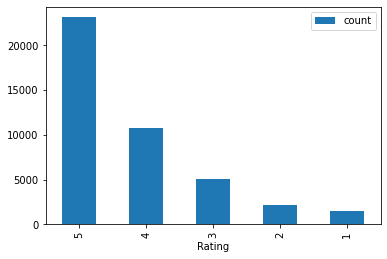

In [ ]:
data.groupBy('Rating').count().sort(desc('count')).toPandas().plot(x='Rating',y='count',kind='bar')
display()

In [ ]:
data.groupBy('Branch').agg({'Rating':'avg'}).sort(desc('avg(Rating)')).show()

+--------------------+-----------------+
|              Branch|      avg(Rating)|
+--------------------+-----------------+
|Disneyland_Califo...|4.405338555086056|
| Disneyland_HongKong|4.204158004158004|
|    Disneyland_Paris| 3.96008804108584|
+--------------------+-----------------+



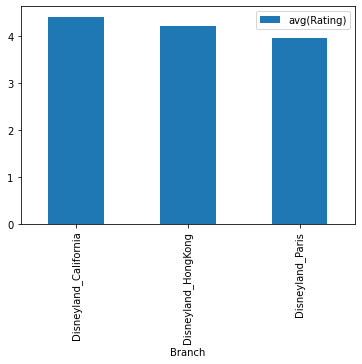

In [ ]:
data.groupby('Branch').agg({"Rating":'avg'}).sort(desc('avg(Rating)')).toPandas().plot(x='Branch',y='avg(Rating)',kind='bar')
display()

In [ ]:
data.groupby('Branch', 'Rating').count().sort(desc('Rating')).show()

+--------------------+------+-----+
|              Branch|Rating|count|
+--------------------+------+-----+
|Disneyland_Califo...|     5|12518|
| Disneyland_HongKong|     5| 4517|
|    Disneyland_Paris|     5| 6111|
|Disneyland_Califo...|     4| 3981|
| Disneyland_HongKong|     4| 3230|
|    Disneyland_Paris|     4| 3564|
|Disneyland_Califo...|     3| 1661|
|    Disneyland_Paris|     3| 2083|
| Disneyland_HongKong|     3| 1365|
|    Disneyland_Paris|     2| 1044|
| Disneyland_HongKong|     2|  336|
|Disneyland_Califo...|     2|  747|
| Disneyland_HongKong|     1|  172|
|Disneyland_Califo...|     1|  499|
|    Disneyland_Paris|     1|  828|
+--------------------+------+-----+



In [ ]:
Cal = data.filter(data['Branch'] == 'Disneyland_California')
Hkg = data.filter(data['Branch'] == 'Disneyland_HongKong')
Par = data.filter(data['Branch'] == 'Disneyland_Paris')

In [ ]:
cal_ratings = Cal.groupby('Month').agg({'Rating':'avg'}).sort(desc('Month'))

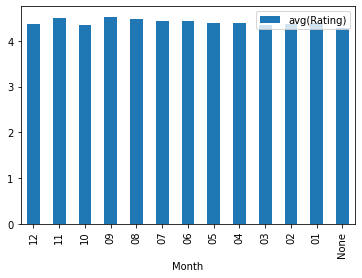

In [ ]:
cal_ratings.toPandas().plot(x='Month',y='avg(Rating)',kind='bar')
display()

In [ ]:
hkg_ratings = Hkg.groupby('Month').agg({'Rating':'avg'}).sort(desc('Month'))

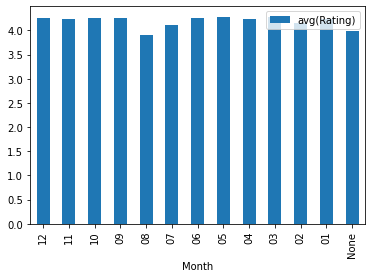

In [ ]:
hkg_ratings.toPandas().plot(x='Month',y='avg(Rating)',kind='bar')
display()

In [ ]:
par_ratings = Par.groupby('Month').agg({'Rating':'avg'}).sort(desc('Month'))

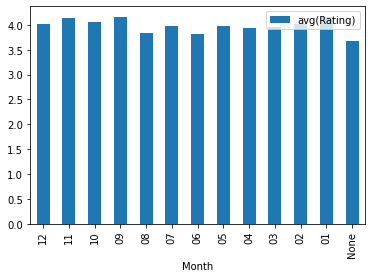

In [ ]:
par_ratings.toPandas().plot(x='Month',y='avg(Rating)',kind='bar')
display()

In [ ]:
cal_visits = Cal.groupby('Month').count().sort(desc('Month'))

<Figure size 432x288 with 0 Axes>

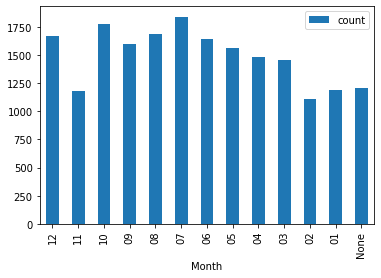

In [ ]:
plt.clf()
cal_visits.toPandas().plot(x='Month',y='count',kind='bar')
display()

In [ ]:
hkg_visits = Hkg.groupby('Month').count().sort(desc('Month'))

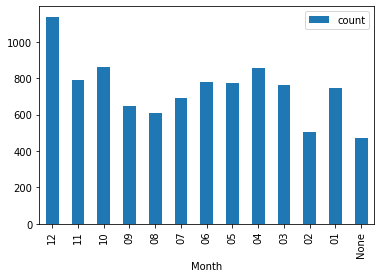

In [ ]:
hkg_visits.toPandas().plot(x='Month',y='count',kind='bar')
display()

In [ ]:
par_visits = Par.groupby('Month').count().sort(desc('Month'))

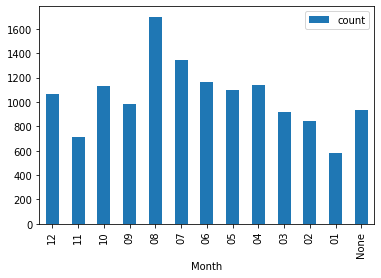

In [ ]:
par_visits.toPandas().plot(x='Month',y='count',kind='bar')
display()

In [ ]:
avg_review_length = data.toPandas().groupby('Rating').Review_Text.apply(lambda x: x.str.split().str.len().mean())

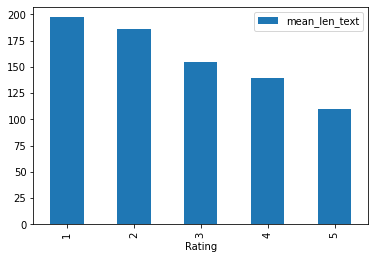

In [ ]:
avg_review_length.reset_index(name='mean_len_text').plot(x='Rating', y='mean_len_text',kind='bar')
display()

In [ ]:
review_len_branch = data.toPandas().groupby(['Branch','Rating']).Review_Text.apply(lambda x: x.str.split().str.len().mean())

In [ ]:
review_len_branch

Branch                 Rating
Disneyland_California  1         188.374749
                       2         176.285141
                       3         143.399759
                       4         128.714142
                       5         100.984343
Disneyland_HongKong    1         137.418605
                       2         102.747024
                       3         100.022711
                       4         107.031579
                       5          98.147000
Disneyland_Paris       1         214.875604
                       2         220.299808
                       3         199.429669
                       4         179.762907
                       5         138.195549
Name: Review_Text, dtype: float64

In [ ]:
data.show(3)

+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|Month|Year|
+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|670772142|     4|2019-04-01|           Australia|If you've ever be...|Disneyland_HongKong|   04|2019|
|670682799|     4|2019-05-01|         Philippines|Its been a while ...|Disneyland_HongKong|   05|2019|
|670623270|     4|2019-04-01|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|   04|2019|
+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
only showing top 3 rows



In [ ]:
data.count()

42656

#### Modeling:
- Binary classification of Ratings (good or bad)
  - Logistic Regression
  - Decision Tree
- Multilabel classification to predict the exact Rating of a Review_Text
  - Random Forest

#### Creating a new dataframe for feature engineering

In [ ]:
my_cols = data.select(['Review_ID','Rating','Review_Text'])
my_data = my_cols.dropna()
my_data.show(3)

+---------+------+--------------------+
|Review_ID|Rating|         Review_Text|
+---------+------+--------------------+
|670772142|     4|If you've ever be...|
|670682799|     4|Its been a while ...|
|670623270|     4|Thanks God it was...|
+---------+------+--------------------+
only showing top 3 rows



- Setting a threshold for Ratings: good = 1, bad = 0. 
- Let's assume that a Rating 3+ is good and a rating of 1 or 2 is bad.

In [ ]:
my_data = my_data.withColumn(
    'label',
    F.when((F.col("Rating") == 3), 1)\
    .when((F.col("Rating") == 4) , 1)\
    .when((F.col("Rating") == 5) , 1)\
    .otherwise(0)
)
my_data.show(3)

+---------+------+--------------------+-----+
|Review_ID|Rating|         Review_Text|label|
+---------+------+--------------------+-----+
|670772142|     4|If you've ever be...|    1|
|670682799|     4|Its been a while ...|    1|
|670623270|     4|Thanks God it was...|    1|
+---------+------+--------------------+-----+
only showing top 3 rows



#### Removing punctuations, etc.

In [ ]:
# Import the necessary functions
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

wrangled = my_data.withColumn('Review_Text', regexp_replace(my_data.Review_Text, '[_():;,.!?\\-]', " "))
wrangled = wrangled.withColumn('Review_Text', regexp_replace(wrangled.Review_Text, '[0-9]', " "))

# Merge multiple spaces
wrangled = wrangled.withColumn('Review_Text', regexp_replace(wrangled.Review_Text, ' +', ' '))

# Split the text into words
wrangled = Tokenizer(inputCol='Review_Text', outputCol="words").transform(wrangled)
 
wrangled.show(4, truncate=True)


+---------+------+--------------------+-----+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|
+---------+------+--------------------+-----+--------------------+
|670772142|     4|If you've ever be...|    1|[if, you've, ever...|
|670682799|     4|Its been a while ...|    1|[its, been, a, wh...|
|670623270|     4|Thanks God it was...|    1|[thanks, god, it,...|
|670607911|     4|HK Disneyland is ...|    1|[hk, disneyland, ...|
+---------+------+--------------------+-----+--------------------+
only showing top 4 rows



#### Removing stop words, etc.

In [ ]:
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

# Remove stop words.
wrangled = StopWordsRemover(inputCol='words', outputCol='terms')\
      .transform(wrangled)
 
# Apply the hashing trick
wrangled = HashingTF(inputCol = 'terms', outputCol = 'hash', numFeatures=1024)\
      .transform(wrangled)


In [ ]:
wrangled.show(4, truncate=True)

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|670772142|     4|If you've ever be...|    1|[if, you've, ever...|[ever, disneyland...|(1024,[26,47,93,1...|
|670682799|     4|Its been a while ...|    1|[its, been, a, wh...|[since, d, last, ...|(1024,[4,27,47,62...|
|670623270|     4|Thanks God it was...|    1|[thanks, god, it,...|[thanks, god, was...|(1024,[2,6,10,35,...|
|670607911|     4|HK Disneyland is ...|    1|[hk, disneyland, ...|[hk, disneyland, ...|(1024,[43,71,83,9...|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 4 rows



#### TF-IDF

In [ ]:
# Convert hashed symbols to TF-IDF
tf_idf = IDF(inputCol = 'hash', outputCol = 'features')\
      .fit(wrangled).transform(wrangled)
      
tf_idf.select('features', 'label').show(3, truncate=True)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1024,[26,47,93,1...|    1|
|(1024,[4,27,47,62...|    1|
|(1024,[2,6,10,35,...|    1|
+--------------------+-----+
only showing top 3 rows



In [ ]:
type(tf_idf)

pyspark.sql.dataframe.DataFrame

Binary classification modeling

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Split the data into training and testing sets
(train_df, test_df) = tf_idf.randomSplit([0.8,0.2], seed=13)



In [ ]:
train_df.show(3)

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|            features|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  3530053|     2|Obviously I haven...|    0|[obviously, i, ha...|[obviously, visit...|(1024,[7,38,40,59...|(1024,[7,38,40,59...|
|  3998899|     4|Visited Hong Kong...|    1|[visited, hong, k...|[visited, hong, k...|(1024,[1,9,19,34,...|(1024,[1,9,19,34,...|
|  4020946|     2|The park is small...|    0|[the, park, is, s...|[park, small, tin...|(1024,[1,7,10,18,...|(1024,[1,7,10,18,...|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
test_df.show(3)

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|            features|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  3924467|     4|Visited Hkg Disne...|    1|[visited, hkg, di...|[visited, hkg, di...|(1024,[24,30,47,6...|(1024,[24,30,47,6...|
|  4048615|     5|I went there on a...|    1|[i, went, there, ...|[went, weekday, c...|(1024,[8,30,33,40...|(1024,[8,30,33,40...|
|  4602416|     4|We visited Hong K...|    1|[we, visited, hon...|[visited, hong, k...|(1024,[39,43,47,6...|(1024,[39,43,47,6...|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
# Fit a Logistic Regression model to the training data
logistic = LogisticRegression(regParam=0.2).fit(train_df)
 
# Make predictions on the testing data
prediction = logistic.transform(test_df)

#### Model Evaluation

In [ ]:
# Create a confusion matrix, comparing predictions to known labels
prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   37|
|    0|       0.0|   91|
|    1|       1.0| 7589|
|    0|       1.0|  626|
+-----+----------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

In [ ]:
# Accuracy measures the proportion of correct predictions
accuracy = (TN +TP)/(TN + TP +FN +FP)
print(accuracy)

0.920532182668105


In [ ]:
# Calculate precision and recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

precision = 0.92
recall    = 1.00


In [ ]:
# Find weighted precision
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binary_evaluator =  BinaryClassificationEvaluator()

# Find AUC
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})
print(auc)

0.9198899675594138


#### Pipeline for Binary Classification, using Logistic Regression

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
 
# Break text into tokens at non-word characters
tokenizer = Tokenizer(inputCol='Review_Text', outputCol='words')
 
# Remove stop words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='terms')
 
# Apply the hashing trick and transform to TF-IDF
hasher = HashingTF(inputCol=remover.getOutputCol(), outputCol="hash")
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="features")
 
# Create a logistic regression object and add everything to a pipeline
logistic = LogisticRegression()
pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf, logistic])


In [ ]:
my_data.show(3)

+---------+------+--------------------+-----+
|Review_ID|Rating|         Review_Text|label|
+---------+------+--------------------+-----+
|670772142|     4|If you've ever be...|    1|
|670682799|     4|Its been a while ...|    1|
|670623270|     4|Thanks God it was...|    1|
+---------+------+--------------------+-----+
only showing top 3 rows



In [ ]:
# create dataframe for Binary Classification pipeline
new_cols = my_data[['Review_Text','label']]
new_df = new_cols.dropna()
new_df.show(3)

# Split the data into training and testing sets
(pipeline_train, pipeline_test) = new_df.randomSplit([0.8,0.2], seed=13)

+--------------------+-----+
|         Review_Text|label|
+--------------------+-----+
|If you've ever be...|    1|
|Its been a while ...|    1|
|Thanks God it was...|    1|
+--------------------+-----+
only showing top 3 rows



In [ ]:
# Train the pipeline on the training data
pipeline = pipeline.fit(pipeline_train)
 
# Make predictions on the testing data
predictions = pipeline.transform(pipeline_test)

In [ ]:
evaluator = BinaryClassificationEvaluator()

evaluator.evaluate(predictions)

0.8092143791584008

In [ ]:
# Create a confusion matrix, comparing predictions to known labels
predictions.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  273|
|    0|       0.0|  254|
|    1|       1.0| 7356|
|    0|       1.0|  460|
+-----+----------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()

In [ ]:
# Calculate precision and recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

precision = 0.94
recall    = 0.96


- Note: Interesting how drop in performance could be because punctuations weren't removed.

#### Pipeline for Binary Classification, using Decision Trees

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
 
# Break text into tokens at non-word characters
tokenizer1 = Tokenizer(inputCol='Review_Text', outputCol='words')
 
# Remove stop words
remover1 = StopWordsRemover(inputCol=tokenizer1.getOutputCol(), outputCol='terms')
 
# Apply the hashing trick and transform to TF-IDF
hasher1 = HashingTF(inputCol=remover1.getOutputCol(), outputCol="hash")
idf1 = IDF(inputCol=hasher1.getOutputCol(), outputCol="features")
 
# Create a decision tree object and add everything to a pipeline
tree = DecisionTreeClassifier()
pipeline2 = Pipeline(stages=[tokenizer1, remover1, hasher1, idf1, tree])

#### Training the model and making predictions

In [ ]:
# Train the pipeline on the training data
pipeline2 = pipeline2.fit(pipeline_train)
 
# Make predictions on the testing data
predictions2 = pipeline2.transform(pipeline_test)

#### Model Evaluation

In [ ]:
evaluator = BinaryClassificationEvaluator()

evaluator.evaluate(predictions2)

0.6368038367529475

In [ ]:
# Create a confusion matrix, comparing predictions to known labels
predictions2.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   36|
|    0|       0.0|   35|
|    1|       1.0| 7593|
|    0|       1.0|  679|
+-----+----------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN_1 = predictions2.filter('prediction = 0 AND label = prediction').count()
TP_1 = predictions2.filter('prediction = 1 AND label = prediction').count()
FN_1 = predictions2.filter('prediction = 0 AND label = 1').count()
FP_1 = predictions2.filter('prediction = 1 AND label = 0').count()
 
# Accuracy measures the proportion of correct predictions
accuracy_1 = (TN_1 +TP_1)/(TN_1 + TP_1 +FN_1 +FP_1)
print(accuracy_1)

0.9142994126812897


In [ ]:
# Calculate precision and recall
precision = TP_1/(TP_1+FP_1)
recall = TP_1/(TP_1+FN_1)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

precision = 0.92
recall    = 1.00


### Modeling to predict exact Ratings of reviews

In [ ]:
data.show(3)

+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|Month|Year|
+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
|670772142|     4|2019-04-01|           Australia|If you've ever be...|Disneyland_HongKong|   04|2019|
|670682799|     4|2019-05-01|         Philippines|Its been a while ...|Disneyland_HongKong|   05|2019|
|670623270|     4|2019-04-01|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|   04|2019|
+---------+------+----------+--------------------+--------------------+-------------------+-----+----+
only showing top 3 rows



#### Creating dataframe with relevant columns

In [ ]:
my_cols2 = data.select(['Rating','Review_Text'])
my_data2 = my_cols2.dropna()
my_data2.show(10)

+------+--------------------+
|Rating|         Review_Text|
+------+--------------------+
|     4|If you've ever be...|
|     4|Its been a while ...|
|     4|Thanks God it was...|
|     4|HK Disneyland is ...|
|     4|the location is n...|
|     3|Have been to Disn...|
|     5|Great place! Your...|
|     3|Think of it as an...|
|     2|Feel so let down ...|
|     5|I can go on talki...|
+------+--------------------+
only showing top 10 rows



In [ ]:
my_data2 = my_data2.withColumn(
    'label',
    F.when((F.col("Rating") == 5), 5)\
    .when((F.col("Rating") == 4) , 4)\
    .when((F.col("Rating") == 3) , 3)\
    .when((F.col("Rating") == 2) , 2)\
    .when((F.col("Rating") == 1) , 1)\
    .otherwise(0)
)
my_data2.show(10)

+------+--------------------+-----+
|Rating|         Review_Text|label|
+------+--------------------+-----+
|     4|If you've ever be...|    4|
|     4|Its been a while ...|    4|
|     4|Thanks God it was...|    4|
|     4|HK Disneyland is ...|    4|
|     4|the location is n...|    4|
|     3|Have been to Disn...|    3|
|     5|Great place! Your...|    5|
|     3|Think of it as an...|    3|
|     2|Feel so let down ...|    2|
|     5|I can go on talki...|    5|
+------+--------------------+-----+
only showing top 10 rows



In [ ]:
my_data2.count()

42656

In [ ]:
wrangled.show()

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|670772142|     4|If you've ever be...|    1|[if, you've, ever...|[ever, disneyland...|(1024,[26,47,93,1...|
|670682799|     4|Its been a while ...|    1|[its, been, a, wh...|[since, d, last, ...|(1024,[4,27,47,62...|
|670623270|     4|Thanks God it was...|    1|[thanks, god, it,...|[thanks, god, was...|(1024,[2,6,10,35,...|
|670607911|     4|HK Disneyland is ...|    1|[hk, disneyland, ...|[hk, disneyland, ...|(1024,[43,71,83,9...|
|670607296|     4|the location is n...|    1|[the, location, i...|[location, city, ...|(1024,[3,36,87,93...|
|670591897|     3|Have been to Disn...|    1|[have, been, to, ...|[disney, world, d...|(1024,[6,8,9,35,5...|
|670585330|     5|G

In [ ]:
wrangled = wrangled.withColumn(
    'label',
    F.when((F.col("Rating") == 5), 5)\
    .when((F.col("Rating") == 4) , 4)\
    .when((F.col("Rating") == 3) , 3)\
    .when((F.col("Rating") == 2) , 2)\
    .when((F.col("Rating") == 1) , 1)\
    .otherwise(0)
)
wrangled.show(10)

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+
|670772142|     4|If you've ever be...|    4|[if, you've, ever...|[ever, disneyland...|(1024,[26,47,93,1...|
|670682799|     4|Its been a while ...|    4|[its, been, a, wh...|[since, d, last, ...|(1024,[4,27,47,62...|
|670623270|     4|Thanks God it was...|    4|[thanks, god, it,...|[thanks, god, was...|(1024,[2,6,10,35,...|
|670607911|     4|HK Disneyland is ...|    4|[hk, disneyland, ...|[hk, disneyland, ...|(1024,[43,71,83,9...|
|670607296|     4|the location is n...|    4|[the, location, i...|[location, city, ...|(1024,[3,36,87,93...|
|670591897|     3|Have been to Disn...|    3|[have, been, to, ...|[disney, world, d...|(1024,[6,8,9,35,5...|
|670585330|     5|G

In [ ]:
wrangled.printSchema()

root
 |-- Review_ID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review_Text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hash: vector (nullable = true)



In [ ]:
tf_idf4 = IDF(inputCol = 'hash', outputCol = 'features')\
      .fit(wrangled).transform(wrangled)
tf_idf4.show()

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|            features|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|670772142|     4|If you've ever be...|    4|[if, you've, ever...|[ever, disneyland...|(1024,[26,47,93,1...|(1024,[26,47,93,1...|
|670682799|     4|Its been a while ...|    4|[its, been, a, wh...|[since, d, last, ...|(1024,[4,27,47,62...|(1024,[4,27,47,62...|
|670623270|     4|Thanks God it was...|    4|[thanks, god, it,...|[thanks, god, was...|(1024,[2,6,10,35,...|(1024,[2,6,10,35,...|
|670607911|     4|HK Disneyland is ...|    4|[hk, disneyland, ...|[hk, disneyland, ...|(1024,[43,71,83,9...|(1024,[43,71,83,9...|
|670607296|     4|the location is n...|    4|[the, location, i...|[location, city, ...|(10

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(tf_idf4)

# Automatically identify categorical features, and index them.

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(tf_idf4)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = tf_idf4.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=50)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Make predictions.
predictions = model.transform(testData)

In [ ]:
# Select example rows to display.
predictions.select("predictedLabel", "label", "features", "Review_Text").show(20, truncate=False)

+--------------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Evaluate Model

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
#print("Test Error = %g" % (1.0 - accuracy))

0.5473696461824954
Test Error = 0.45263


#### Model Summary

In [ ]:
rfModel = model.stages[2]
print(rfModel)  # summary only

RandomForestClassificationModel: uid=RandomForestClassifier_b17042230059, numTrees=50, numClasses=5, numFeatures=1024


#### Multi-label Logistic Regression

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(tf_idf4)

# Automatically identify categorical features, and index them.

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(tf_idf4)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = tf_idf4.randomSplit([0.8, 0.2])

# Train a RandomForest model.
logr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.5898063914159085


#### Using Logistic Regression to make predictions on external reviews. Use case: Reviews from Trip Advisor on Disneyland

In [ ]:
data = [("Everyone knows how amazing Disney is! It is an all day affair and more! The different lands are creative and fun with rides around each theme. It is the cleanest amusement park even when there are a lot of people!",5),("We can’t wait to go back. I was lucky enough to take my family just before covid hit North America hard and shut the parks down. It is truly the most magical place on earth. Dreams came true and the magic was everywhere.", 5), ("Disneyland has changed dramatically. I remember happy quaint park. Now too crowded Spent more time walking and waiting hours for rides.Got on a few rides even with fast passes in four days.We got very little accomplished in four days. Miss the days of characters roaming. Waiting in line for them is hard for young children", 1)]

rdd = spark.sparkContext.parallelize(data)

dfFromRDD1 = rdd.toDF()

columns = ["review","label"]
dfFromRDD1 = rdd.toDF(columns)
dfFromRDD1.printSchema()

root
 |-- review: string (nullable = true)
 |-- label: long (nullable = true)



In [ ]:
# Break text into tokens at non-word characters
tokenizer10 = Tokenizer(inputCol='review', outputCol='words').transform(dfFromRDD1)

In [ ]:
tokenizer10.show()

+--------------------+-----+--------------------+
|              review|label|               words|
+--------------------+-----+--------------------+
|Everyone knows ho...|    5|[everyone, knows,...|
|We can’t wait to ...|    5|[we, can’t, wait,...|
|Disneyland has ch...|    1|[disneyland, has,...|
+--------------------+-----+--------------------+



In [ ]:
# Remove stop words
remover10 = StopWordsRemover(inputCol='words', outputCol='terms')\
      .transform(tokenizer10)
remover10.show()

+--------------------+-----+--------------------+--------------------+
|              review|label|               words|               terms|
+--------------------+-----+--------------------+--------------------+
|Everyone knows ho...|    5|[everyone, knows,...|[everyone, knows,...|
|We can’t wait to ...|    5|[we, can’t, wait,...|[can’t, wait, go,...|
|Disneyland has ch...|    1|[disneyland, has,...|[disneyland, chan...|
+--------------------+-----+--------------------+--------------------+



In [ ]:
# Apply the hashing trick and transform to TF-IDF
hasher10 = HashingTF(inputCol='terms', outputCol="hash", numFeatures=1024)\
      .transform(remover10)
hasher10.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|              review|label|               words|               terms|                hash|
+--------------------+-----+--------------------+--------------------+--------------------+
|Everyone knows ho...|    5|[everyone, knows,...|[everyone, knows,...|(1024,[109,110,14...|
|We can’t wait to ...|    5|[we, can’t, wait,...|[can’t, wait, go,...|(1024,[18,19,131,...|
|Disneyland has ch...|    1|[disneyland, has,...|[disneyland, chan...|(1024,[10,103,115...|
+--------------------+-----+--------------------+--------------------+--------------------+



In [ ]:
 #Convert hashed symbols to TF-IDF
tf_idf_10 = IDF(inputCol = 'hash', outputCol = 'features')\
      .fit(hasher10).transform(hasher10)
      
tf_idf_10.select('features', 'label','review','words','terms','hash').show(3, truncate=True)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|            features|label|              review|               words|               terms|                hash|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|(1024,[109,110,14...|    5|Everyone knows ho...|[everyone, knows,...|[everyone, knows,...|(1024,[109,110,14...|
|(1024,[18,19,131,...|    5|We can’t wait to ...|[we, can’t, wait,...|[can’t, wait, go,...|(1024,[18,19,131,...|
|(1024,[10,103,115...|    1|Disneyland has ch...|[disneyland, has,...|[disneyland, chan...|(1024,[10,103,115...|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+



In [ ]:
trainingData.show(3)

+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Review_ID|Rating|         Review_Text|label|               words|               terms|                hash|            features|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  3530053|     2|Obviously I haven...|    2|[obviously, i, ha...|[obviously, visit...|(1024,[7,38,40,59...|(1024,[7,38,40,59...|
|  3924467|     4|Visited Hkg Disne...|    4|[visited, hkg, di...|[visited, hkg, di...|(1024,[24,30,47,6...|(1024,[24,30,47,6...|
|  4020946|     2|The park is small...|    2|[the, park, is, s...|[park, small, tin...|(1024,[1,7,10,18,...|(1024,[1,7,10,18,...|
+---------+------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
tf_idf_10.show(3)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+
|              review|label|               words|               terms|                hash|            features|Review_ID|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+
|Everyone knows ho...|    5|[everyone, knows,...|[everyone, knows,...|(1024,[109,110,14...|(1024,[109,110,14...|     1254|
|We can’t wait to ...|    5|[we, can’t, wait,...|[can’t, wait, go,...|(1024,[18,19,131,...|(1024,[18,19,131,...|     1254|
|Disneyland has ch...|    1|[disneyland, has,...|[disneyland, chan...|(1024,[10,103,115...|(1024,[10,103,115...|     1367|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+



In [ ]:
tf_idf_10 = tf_idf_10.withColumn(
    'Review_ID',
    F.when((F.col("label") == 1), 1367)\
    .when((F.col("label") == 5) , 1254)\
    .otherwise(0)
)
tf_idf_10.show(3)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+
|              review|label|               words|               terms|                hash|            features|Review_ID|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+
|Everyone knows ho...|    5|[everyone, knows,...|[everyone, knows,...|(1024,[109,110,14...|(1024,[109,110,14...|     1254|
|We can’t wait to ...|    5|[we, can’t, wait,...|[can’t, wait, go,...|(1024,[18,19,131,...|(1024,[18,19,131,...|     1254|
|Disneyland has ch...|    1|[disneyland, has,...|[disneyland, chan...|(1024,[10,103,115...|(1024,[10,103,115...|     1367|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------+



#### Multi-label Decision Trees

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(tf_idf4)

# Automatically identify categorical features, and index them.

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(tf_idf4)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = tf_idf4.randomSplit([0.8, 0.2])

# Train a RandomForest model.
tre = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, tre, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.5438762253454589


Thank you!